# Extraction + Learning : Hardware Spec Sheets

This notebook demonstrates the full entity extraction process on transistor data sheets, extracting min/max storage temperatures.

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from snorkel.parser import HTMLParser
html_parser = HTMLParser(path='data/hardware_docs/')

In [3]:
from snorkel.parser import TableParser
table_parser = TableParser()

In [4]:
from snorkel.parser import Corpus
%time corpus = Corpus(html_parser, table_parser, max_docs=100)

Parsing documents...
Parsing contexts...
Parsed 98 documents and 630 contexts
CPU times: user 1min 11s, sys: 3.55 s, total: 1min 14s
Wall time: 1min 51s


In [5]:
from snorkel.candidates import TableNgrams
from snorkel.matchers import NumberMatcher, RangeMatcher

# Define a candidate space
table_ngrams = TableNgrams(n_max=3)

# Define a matcher
number_matcher = RangeMatcher(low=-80,high=-40)
# number_matcher = NumberMatcher()

In [50]:
from snorkel.candidates import Candidates
%time candidates = Candidates(table_ngrams, number_matcher, corpus.get_contexts())
for c in candidates.get_candidates()[:5]: print c

Extracting candidates...
CPU times: user 5.66 s, sys: 105 ms, total: 5.76 s
Wall time: 5.71 s
<TableNgram("-50", id=71-0-10-0:0-2, chars=[0,2], (row,col)=(2,2), tag=td)
<TableNgram("-50", id=97-1-22-0:0-2, chars=[0,2], (row,col)=(2,6), tag=td)
<TableNgram("-65", id=37-0-37-0:0-2, chars=[0,2], (row,col)=(10,2), tag=td)
<TableNgram("-65", id=37-0-17-0:0-2, chars=[0,2], (row,col)=(5,2), tag=td)
<TableNgram("-50", id=2-3-71-0:4-6, chars=[4,6], (row,col)=(16,0), tag=td)


Now make gold data:

In [52]:
import csv
with open('data/gold_stg_temp_min.csv', 'rb') as csvfile:
    gold_reader = csv.reader(csvfile)
    gold = []
    for row in gold_reader:
        (doc, part, temp, label) = row
        if label=='stg_temp_min':
            gold.append((doc,temp))
validation = 0
train = 1 - validation
gold = list(set(gold))
print "%s gold annotations" % len(gold)
gt_dict = {}
for c in candidates.get_candidates():
    filename = (corpus.get_doc(c.doc_id).file).split('.')[0]
    temp = c.get_attrib_span('words')
    label = 1 if (filename, temp) in gold else -1
    gt_dict[c.uid] = label
print "%s out of %s candidates are positive" % (gt_dict.values().count(1), len(gt_dict))

98 gold annotations
63 out of 163 candidates are positive


Confirm that features work:

In [10]:
from snorkel.features import TableNgramFeaturizer
featurizer = TableNgramFeaturizer(candidates, corpus)
featurizer.get_features_by_id(candidates.get_candidates()[0].id)[:10]

Extracting features...
Extracted 1951 features for each of 163 candidates


[u'BASIC_NGRAM_-50',
 'TABLE_ROW_NUM_2',
 'TABLE_COL_NUM_2',
 'TABLE_HTML_TAG_td',
 'TABLE_HTML_ATTR_style=width:89pt',
 'TABLE_HTML_ANC_TAG_tr',
 'TABLE_HTML_ANC_TAG_table',
 'TABLE_HTML_ANC_TAG_li',
 'TABLE_HTML_ANC_TAG_ul',
 'TABLE_HTML_ANC_TAG_body']

We now build a legacy DDLiteModel with which we will do the learning stages.

In [54]:
# import cPickle
# pkl_f = 'data/hardware_gold_train.pkl'
# with open(pkl_f, 'rb') as f:
#     gt_dict = cPickle.load(f)


from snorkel.snorkel import DDLiteModel
DDL = DDLiteModel(candidates.get_candidates(), featurizer.get_features(), gt_dict)

DDL.set_holdout(idxs=range(50), validation_frac=0.5)
print "%s training data" % len(gt.get_labeled_ground_truth('training')[0])
print "%s test data" % len(gt.get_labeled_ground_truth('test')[0])
print "%s validation data" % len(gt.get_labeled_ground_truth('validation')[0])

113 training data
25 test data
25 validation data


In [43]:
# NOTE: make sure that these are made case insensitive
def LF_to(m):
    return 1 if 'to' in m.post_window('words') else 0
def LF_storage(m):
    return 1 if 'Storage' in m.aligned('words') else 0
def LF_tstg(m):
    return 1 if 'Tstg' in m.aligned('words') else 0
def LF_temperature(m):
    return 1 if 'Temperature' in m.aligned('words') else 0

def LF_n(m):
    return -1 if m.n > 1 else 0

In [56]:
LFs = [LF_to, LF_storage, LF_tstg, LF_temperature, LF_n]
DDL.apply_lfs(LFs, clear=True)

In [57]:
# View LF performance on a particular candidate
c = candidates.get_candidates()[8]
print c
for lf in LFs:
    print lf(c)

<TableNgram("-55", id=80-1-33-0:0-2, chars=[0,2], (row,col)=(6,3), tag=td)
0
1
1
0
0


In [58]:
print DDL.lf_names
DDL.print_lf_stats()

['LF_to', 'LF_storage', 'LF_tstg', 'LF_temperature', 'LF_n']
LF stats on training set
Coverage:	40.708%
Overlap:	32.743%
Conflict:	0.000%


In [59]:
DDL.top_conflict_lfs(n=3)

Labeling function,Percent candidates where LF has conflict
LF_n,0.00%
LF_storage,0.00%
LF_temperature,0.00%


In [60]:
DDL.lowest_coverage_lfs(n=3)

Labeling function,Candidate coverage
LF_n,0.00%
LF_tstg,15.04%
LF_to,22.12%


Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.740326
	Learning epoch = 250	Gradient mag. = 1.298773
Final gradient magnitude for rate=0.01, mu=1e-07: 1.529
Running in False mode...
Begin training for rate=0.01, mu=1e-09
	Learning epoch = 0	Gradient mag. = 0.473189
	Learning epoch = 250	Gradient mag. = 0.484603
	Learning epoch = 500	Gradient mag. = 0.471709
	Learning epoch = 750	Gradient mag. = 0.459387
	Learning epoch = 1000	Gradient mag. = 0.447609
	Learning epoch = 1250	Gradient mag. = 0.436347
	Learning epoch = 1500	Gradient mag. = 0.425575
	Learning epoch = 1750	Gradient mag. = 0.415270
	Learning epoch = 2000	Gradient mag. = 0.405407
	Learning epoch = 2250	Gradient mag. = 0.395965
	Learning epoch = 2500	Gradient mag. = 0.386922
	Learning epoch = 2750	Gradient mag. = 0.378260
Final gradient magnitude for rate=0.01, mu=1e-09: 0.370
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.473189
	Learning epoch = 250	Gradient mag. = 0

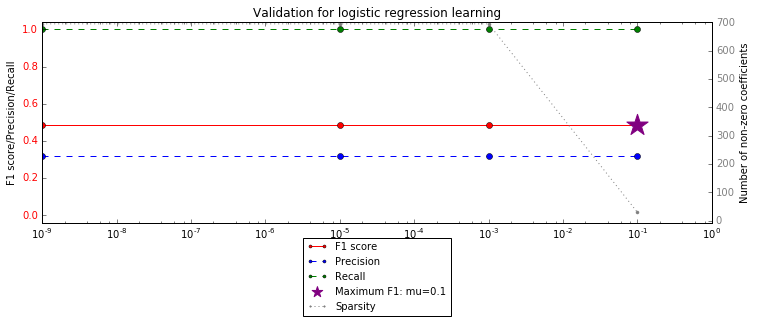

CPU times: user 4.21 s, sys: 60.4 ms, total: 4.27 s
Wall time: 4.3 s


<snorkel.snorkel.ModelLog instance at 0x11b0220e0>

In [62]:
import matplotlib
import numpy as np
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,4)
mu_seq = np.ravel([1e-9, 1e-5, 1e-3, 1e-1])
lf_opts = {'sample': False, 'verbose': True}
model_opts = {'sample': False, 'n_iter': 3000, 'alpha': 0.5, 'mu': mu_seq, 'bias': False, 'verbose': True}
%time DDL.train_model(method='lr', lf_opts=lf_opts, model_opts=model_opts)